Approximate PageRank-Nibble

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import cmath

In [2]:
# Input:
# - the graph of the network
# - a dictionary of target nodes with, as value, the initial residual
#   (it can accept more than one target node)
# - the teleport constant alpha
# - a target precision epsilon
#
# Output:
# - a PageRank dictionary
#
#
def approximatePageRank(G, target_nodes, alpha, epsilon):

    # Initialization
    D = 2*G.number_of_edges()
    # PageRank
    p = {}
    # Residuals
    r = target_nodes.copy()
    # Degrees
    d = {}
    for n in target_nodes:
        d[n] = G.degree(n)

    # Calculate the initial queue based on the "r / d >= epsilon" condition
    queue = [key for key in r.keys() if (d[key] > 0) and (r[key] >= epsilon * d[key]/D)]

    # Iterate until the queue is not empty
    while(queue):

        # Take the first element of the queue
        node_u = queue[0]
        
        # Perform the push operation
        # Update the PageRank dictionary
        if node_u in p:
            p[node_u] += (1-alpha) * r[node_u]
        else:
            p[node_u] = (1-alpha) * r[node_u]
        
        # Update the residual of the node u
        r[node_u] = alpha * r[node_u] / 2
        #r[node_u] = alpha * r[node_u]

        # Compute the new residuals of the neighbors of u
        for node_v in G.neighbors(node_u):
            if node_v in r:
                r[node_v] += r[node_u] / d[node_u]
                #r[node_v] += r[node_u]
            else:
                r[node_v] = r[node_u] / d[node_u]
                #r[node_v] = r[node_u]
                d[node_v] = G.degree(node_v)

        # Recompute the queue
        queue = [key for key in r.keys() if (d[key] > 0) and (r[key] >= epsilon * d[key]/D)]

    return p

In [3]:
def conductance_sweep(A):
    a = np.sum(np.triu(A), axis=0)
    b = np.sum(np.tril(A), axis=0)
    D = np.sum(a+b)
    assoc = np.cumsum(a+b)
    assoc = [min(a, D - a) for a in assoc]
    cut = np.cumsum(b-a)
    conduct = cut/assoc
    conduct = conduct[0:-1]
    return conduct

In [4]:
def arrayFromDict(p):

    # Get values and keys from the dictionary
    p_values = list(p.values())
    p_keys = np.array(list(p.keys()))

    # Normalize PageRank vector
    p_values = np.array(p_values) / sum(p_values)

    # Compute an array filling the missing nodes with zeros
    p_V = np.zeros(np.max(p_keys)+1)
    p_V[p_keys] = p_values

    return p_V

In [5]:
#Set-up parameters
c = 0.85
q = {0:1}
epsilon = 1e-3

In [6]:
jain = pd.read_table('data/jain.txt', header=None)
jain.head()

,0,1,2
0,0.85,17.45,2
1,0.75,15.60,2
2,3.30,15.45,2
3,5.25,14.20,2
4,4.90,15.65,2


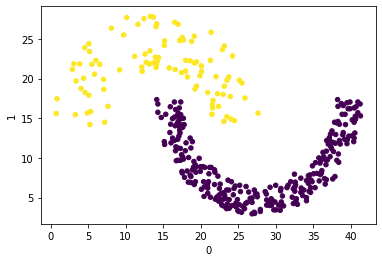

In [7]:
#visualize the dataset (with clusters)
jain.plot.scatter(x=0, y=1, c=2, colormap='viridis', colorbar=False);

In [8]:
re = jain[0]
im = jain[1]
v = np.array([complex(re[i], im[i]) for i in range(len(re))])
print(v.shape)

(373,)


In [9]:
#extract adjacency matrix
A = 1*(abs(v[:, np.newaxis] - v)<=4)
A = A - np.diag(np.diag(A))
N = A.shape[0]
G = nx.from_numpy_matrix(A)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 373
Number of edges: 7628
Average degree:  40.9008


In [11]:
'''
r2 = nx.pagerank(G, personalization=q)
r2_v = np.array(list(r2.values()))
'''
print()

In [12]:
#infinite precision
#sweep
'''
pos2 = np.flip(np.argsort(r2_v))
u1s = np.flip(np.sort(r2_v))
Nmax1 = np.argwhere(u1s>0)[-1].squeeze()
Ap = np.zeros((N,N))
for x,i in enumerate(pos2):
    for y,j in enumerate(pos2):
        Ap[x,y] = A[i,j]
conduct = conductance_sweep(Ap)
conduct = conduct[0:Nmax1]

plt.plot(conduct)
plt.show()

#minimum
mpos2 = np.argmin(conduct)

#communities
C1 = np.sort(pos2[0:mpos2+1])
C2 = np.sort(pos2[mpos2+2:])

#plot
x1 = [x.real for x in v[C1]]
y1 = [x.imag for x in v[C1]]
x2 = [x.real for x in v[C2]]
y2 = [x.imag for x in v[C2]]
plt.scatter(x1,y1)
plt.scatter(x2, y2)
'''
print()


In [16]:
r2_app = approximatePageRank(G, q, c, epsilon)
r2_app_val = arrayFromDict(r2_app)
z = np.zeros(N - len(r2_app_val))
r2_app_val = np.concatenate((r2_app_val, z))

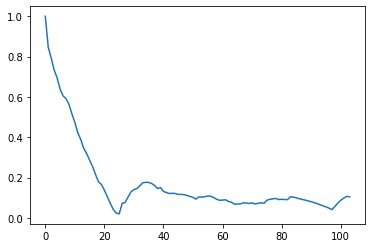

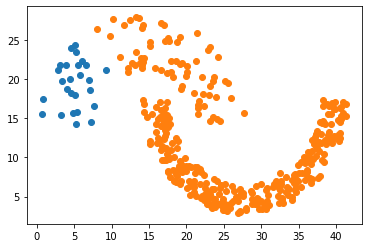

In [17]:
#finite precision
pos2 = np.flip(np.argsort(r2_app_val))
u2s = np.flip(np.sort(r2_app_val))
Nmax = np.argwhere(u2s>0)[-1].squeeze()
Ap_ap = np.zeros((N,N))
for x,i in enumerate(pos2):
    for y,j in enumerate(pos2):
        Ap_ap[x,y] = A[i,j]
conduct = conductance_sweep(Ap_ap)
conduct = conduct[0:Nmax]

plt.plot(conduct)
plt.show()

#minimum
mpos2 = np.argmin(conduct)

#communities
C1 = np.sort(pos2[0:mpos2+1])
C2 = np.sort(pos2[mpos2+2:])

#plot
x1 = [x.real for x in v[C1]]
y1 = [x.imag for x in v[C1]]
x2 = [x.real for x in v[C2]]
y2 = [x.imag for x in v[C2]]
plt.scatter(x1,y1)
plt.scatter(x2, y2)